# Module: calibration

This module contains functions for calibration of 4DSTEM data, including calibrating pixel sizes, calibrating the rotational offset between the real and diffraction planes, correcting diffraction shifts, and correcting elliptical distortions.

### Correct ellitical distortions, no beam stop

This notebook demos measuring and correction elliptical distortion of the diffraction patterns due to imperfect electron optics.  This notebook requires that the Bragg peaks and average deconvolution have already been measured, and if necessary, the diffraction shifts corrected. We proceed as follows:

Measure elliptical distortion
1. Get the unscattered beam position
2. Specify an annular fitting region
3. Fit an ellipse

Correct elliptical distortion
1. Correct the Bragg peak positions
2. (optional) Correct the data, creating a new, corrected datacube. Note that this requires having sufficient memory, and is frequenly not necessary.

### Import packages, load data

In [374]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import leastsq
import numpy.ma as ma
from matplotlib.patches import Circle, Ellipse

from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.readwrite import FileBrowser, read, append
from py4DSTEM.process.braggdiskdetection import get_deconvolution

from py4DSTEM.process.calibration import get_diffraction_shifts, find_outlier_shifts
from py4DSTEM.process.fit import fit_2D
from py4DSTEM.process.calibration import shift_braggpeaks
from py4DSTEM.process.utils import radial_integral, get_maxima_1D

In [375]:
# Get data

fp_braggpeaks = "/home/ben/Data/20190302_calibrationData_Al_standards/NoBeamStop__from_20190307_LiFePO4_100percentLithiated/processing_from_lauren/Al_Probe_cl-300mm_Bragg_disks_shift_corrected.h5"
fp_deconvolution = "/home/ben/Data/20190302_calibrationData_Al_standards/NoBeamStop__from_20190307_LiFePO4_100percentLithiated/processing_from_lauren/Al_Probe_cl-300mm_deconvolution.h5"

braggpeaks = read(fp_braggpeaks)
deconvolution = read(fp_deconvolution).data2D

R_Nx,R_Ny = braggpeaks.shape
Q_Nx,Q_Ny = 1024,1024

/home/ben/Data/20190302_calibrationData_Al_standards/NoBeamStop__from_20190307_LiFePO4_100percentLithiated/processing_from_lauren/Al_Probe_cl-300mm_Bragg_disks_shift_corrected.h5 is a py4DSTEM file, v0.2. Reading...
/home/ben/Data/20190302_calibrationData_Al_standards/NoBeamStop__from_20190307_LiFePO4_100percentLithiated/processing_from_lauren/Al_Probe_cl-300mm_deconvolution.h5 is a py4DSTEM file, v0.2. Reading...


### Measure elliptical distortion

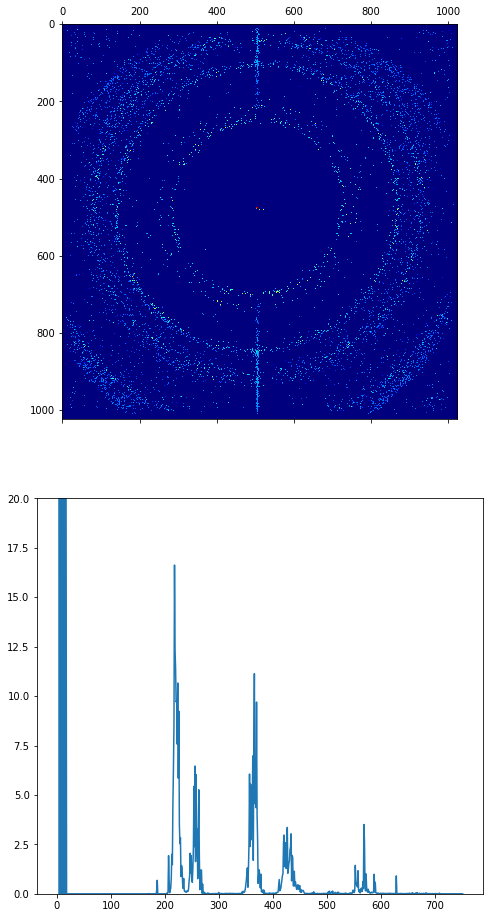

In [376]:
# Deconvolution and radial integral

ymax=20
power=0.1

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(deconvolution,2)),(Q_Nx,Q_Ny))
radial_profile = radial_integral(deconvolution,x0,y0)[0]

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,16))
ax1.matshow(deconvolution**power,cmap='jet')
ax2.plot(np.arange(len(radial_profile)),radial_profile)
ax2.set_ylim(0,ymax)
plt.show()

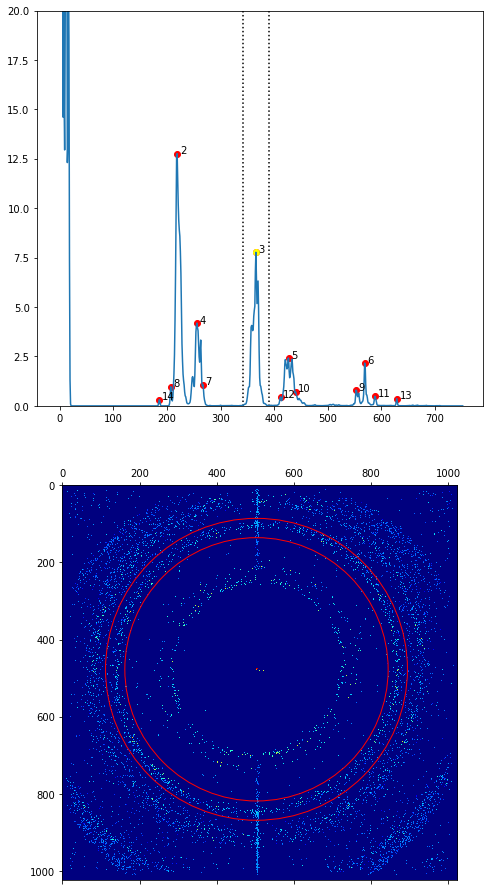

In [377]:
# Get radial profile maxima, and select one

##### Parameters #####
# Find maxima
sigma = 1
minSpacing = 10
minRelativeIntensity = 0.01
relativeToPeak = 1

# Select a maximum
selected_index = 3
annulus_width = 50

# Display params
ymax=20
text_offset = 5
power = 0.1
#######################

maxima = get_maxima_1D(radial_profile, sigma=sigma, minSpacing=minSpacing,
                       minRelativeIntensity=minRelativeIntensity,
                       relativeToPeak=relativeToPeak)

r_peak = maxima[selected_index]
r_inner = r_peak - annulus_width/2.
r_outer = r_peak + annulus_width/2.

# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,16))
ax1.plot(np.arange(len(profile_smoothed)),profile_smoothed)
ax1.scatter(maxima,profile_smoothed[maxima],color='r')
for i in range(len(maxima)):
    if profile_smoothed[maxima[i]] < ymax:
        ax1.text(maxima[i]+text_offset,profile_smoothed[maxima[i]],'{}'.format(i))
ax1.scatter(r_peak,profile_smoothed[r_peak],color='yellow')
ax1.vlines((r_inner,r_outer),0,ax1.get_ylim()[1],linestyle=":")
ax1.set_ylim(0,ymax)

ax2.matshow(deconvolution**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False, edgecolor='r', linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False, edgecolor='r', linestyle="-")
ax2.add_patch(circle_inner)
ax2.add_patch(circle_outer)

plt.show()

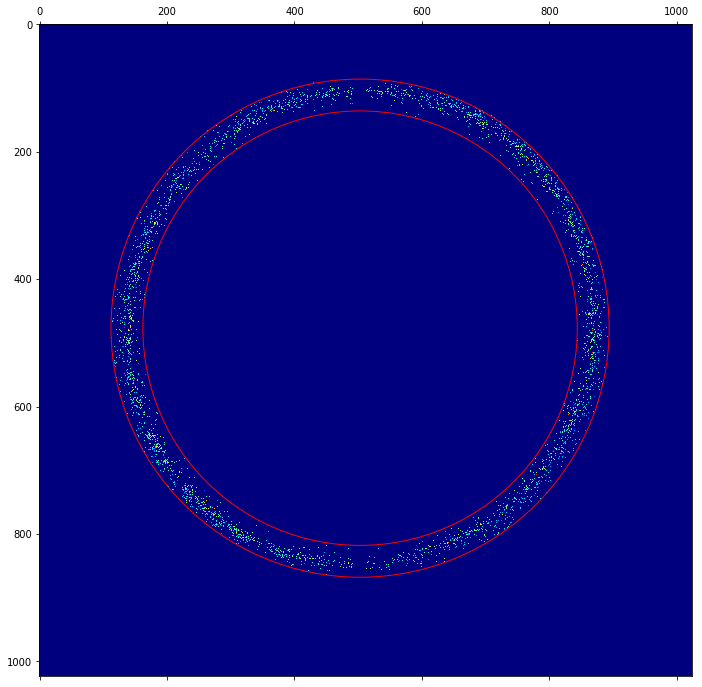

In [405]:
qy,qx = np.meshgrid(np.arange(Q_Ny),np.arange(Q_Nx))
qr = np.sqrt((qx-x0)**2+(qy-y0)**2)
mask = (qr > r_inner) * (qr <= r_outer)
mask[:,y0-10:y0+10]=False

fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(mask*deconvolution**0.1,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
plt.show()

#### Fitting ellipses

The representation of an ellipse we'll use for fitting purposes is

\begin{equation}
A(x-x_0)^2 + B(x-x_0)(y-y_0) + C(y-y0)^2 = 1
\end{equation}

The coordinates are $x$, $y$, and we will fit the five parameters $p = (x_0, y_0, A, B, C)$.  For some datapoint with intensity $I$ at $x_d$, $y_d$, we associate an error with respect to parameters $p$ given by $E(x_d,y_d,I; p) = I\cdot(A(x_d-x_0)^2 + B(x_d-x_0)(y_d-y_0) + C(y_d-y0)^2 - 1)$.  We find the best fit ellipse by finding

\begin{equation}
\underset{p}{\mathrm{argmin}} \sum_i E(x_i,y_i,I_i; p)^2
\end{equation}

where the sum runs over all datapoints $(x_i,y_i,I_i)$.

#### Converting representations

The parameters $x_0, y_0$ are the ellipse center; the parameters $A, B, C$ are related to the semiaxes and rotation.  Here, we briefly show that we can extract the semiaxes $a,b$ and rotation $\theta$ via:

\begin{equation}
\begin{matrix}
a^2    &=& \frac{2}{A+(A-C)\left(1+(\frac{B}{A-C})^2\right)+C}       \\
b^2    &=& \frac{2}{A-(A-C)\left(1+(\frac{B}{A-C})^2\right)+C}       \\
\theta &=& \frac{1}{2}\tan^{-1}\left(\frac{B}{A-C}\right)
\end{matrix}
\end{equation}

To derive these conversions, we begin from the representation of an ellipse

\begin{equation}
\frac{x'^2}{a^2} + \frac{y'^2}{b^2} = 1
\end{equation}

where $a$ and $b$ are the semiaxes, oriented along the $x'$ and $y'$ axes, respectively.  Now let $(x',y')$ be rotated counterclockwise by $\theta$ with respect to a coordinate system $(x,y)$.  Then

\begin{equation}
\begin{pmatrix}
x' \\
y'
\end{pmatrix}
=
\begin{pmatrix}
\cos\theta   &  \sin\theta  \\
-\sin\theta  &  \cos\theta
\end{pmatrix}
\begin{pmatrix}
x \\
y
\end{pmatrix}
\end{equation}

and the ellipse is

\begin{equation}
\frac{(x\cos\theta + y\sin\theta)^2}{a^2} + \frac{(-y\sin\theta + x\cos\theta)^2}{b^2} = 1
\end{equation}

which is equivalent to the ellipse from the prior section, where

\begin{equation}
\begin{matrix}
A &=& \frac{\cos^2\theta}{a^2} + \frac{\sin^2\theta}{b^2}        \\
B &=& 2\sin\theta\cos\theta\left(\frac{-a^2+b^2}{a^2b^2}\right)  \\
C &=& \frac{\sin^2\theta}{a^2} + \frac{\cos^2\theta}{b^2}
\end{matrix}
\end{equation}

The task at hand is to solve these three equations for $a, b, \theta$.

From the second equation, using $2\sin\theta\cos\theta = \sin2\theta$ we find $\frac{B}{\sin2\theta} = \frac{1}{a^2} - \frac{1}{b^2}$.

Subtracting the first and third equations and using $\cos^2\theta - \sin^2\theta = \cos2\theta$, we find $\frac{A-C}{\cos2\theta} = \frac{1}{a^2} - \frac{1}{b^2}$.

Setting these two results equal to one another, we find $\theta = \frac{1}{2}\tan^{-1}\left(\frac{B}{A-C}\right)$.

Adding the first and third equations gives $A+C=\frac{1}{a^2}+\frac{1}{b^2}$, and combining this with $\frac{B}{\sin2\theta}  =\frac{1}{a^2} - \frac{1}{b^2}$ by adding and subtracting gives, respectively:

\begin{equation}
a^2 = \frac{2}{A+\frac{B}{\sin2\theta}+C}        \\
b^2 = \frac{2}{A-\frac{B}{\sin2\theta}+C} 
\end{equation}

Recalling that $\sin(\tan^{-1}(\alpha)) = \frac{\alpha}{\sqrt{1+\alpha^2}}$, we substitute our expression for $\theta$ into $\sin2\theta$ and find $\frac{B}{\sin2\theta} = (A-C)\left(1+(\frac{B}{A-C})^2\right)^\frac{1}{2}$.  Substituting into the expressions above for $a^2$ and $b^2$ completes the derivation.

In [406]:
def ellipse_err(p, x, y, val):
    """
    Returns the error associated with point (x,y), which has value val, with respect to the ellipse given by
    parameters p, where
        p[0] = x0
        p[1] = y0
        p[2] = A
        p[3] = B
        p[4] = C
    And the ellipse is
        $ A(x-x0)^2 + B(x-x0)(y-y0) + C(y-y0)^2 = 1 $
    """
    x,y = x-p[0],y-p[1]
    return (p[2]*x**2 + p[3]*x*y + p[4]*y**2 - 1) * val

In [407]:
def convert_ellipse_params(A,B,C):
    """
    Takes A, B, and C for an ellipse parametrized by
        $ A(x-x0)^2 + B(x-x0)(y-y0) + C(y-y0)^2 = 1 $
    and returns the semi-axes (a,b), tilt in degrees (theta), and eccentricity (e)
    """
    x=(A-C)*np.sqrt(1+(B/(A-C))**2)
    a = np.sqrt(2/(A+C+x))
    b = np.sqrt(2/(A+C-x))
    theta = np.degrees(0.5*np.arctan(B/(A-C)))
    e = np.sqrt(1 - (min(a,b)/max(a,b))**2)
    return a,b,theta,e

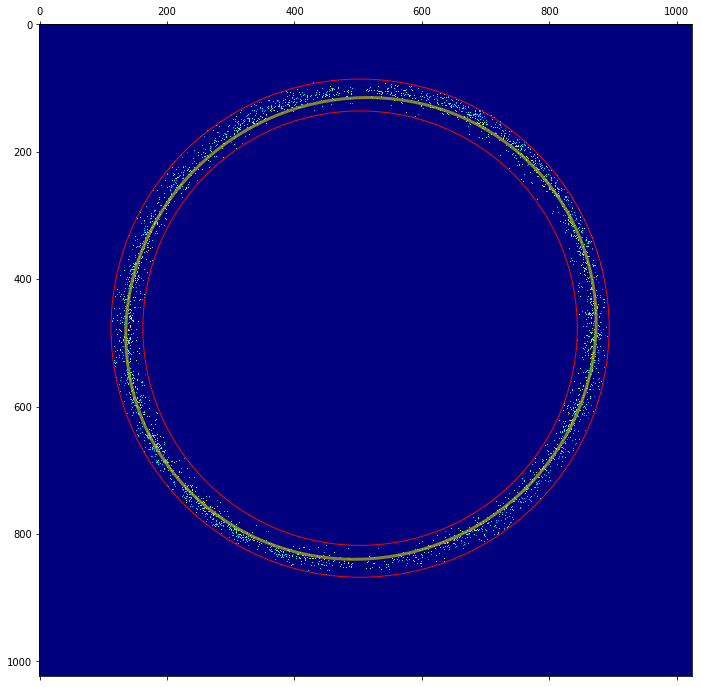

In [408]:
# Fit an ellipse

# Get initial parameters guess
p0_0 = x0
p0_1 = y0
p0_2 = (2/(r_inner+r_outer))**2
p0_3 = 0
p0_4 = (2/(r_inner+r_outer))**2
p0 = [p0_0,p0_1,p0_2,p0_3,p0_4]

# Get datapoints
xs,ys = np.nonzero(mask)
vals = deconvolution[mask]

# Fit
popt = leastsq(ellipse_err, p0, args=(xs,ys,vals))[0]

# Unpack answer and convert to standard form
x0_fit, y0_fit, A_fit, B_fit, C_fit = popt
a_fit, b_fit, theta_fit, e_fit = convert_ellipse_params(A_fit, B_fit, C_fit)

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(mask*deconvolution**0.1,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y0_fit,x0_fit),2*a_fit,2*b_fit,theta_fit, fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
plt.show()

### Simulated data

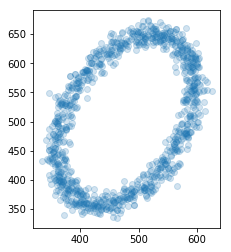

In [386]:
a = 100
b = 160
theta = 30       # in degrees
n_points = 1000
noisescale = 10
theta = np.radians(theta)

def ellipse_sim(t, x0, y0, a, b, theta):
    x = a*np.cos(t)
    y = b*np.sin(t)
    
    xr = np.cos(theta)*x + np.sin(theta)*y
    yr = -np.sin(theta)*x + np.cos(theta)*y
    return xr+x0,yr+y0

t = np.linspace(0,2*np.pi,n_points)
x_sim,y_sim = ellipse_sim(t,x0,y0,a,b,theta)
rand = np.random.normal(0,noisescale,size=(n_points,2))
x_sim += rand[:,0]
y_sim += rand[:,1]

fig,ax = plt.subplots()
ax.scatter(x_sim,y_sim,alpha=0.2)
ax.set_aspect('equal')
plt.show()

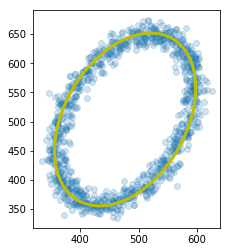

In [390]:
# Fit an ellipse

# Get initial parameters guess
p0_0 = x0+np.random.normal(0,noisescale)
p0_1 = y0+np.random.normal(0,noisescale)
p0_2 = a+np.random.normal(0,noisescale)
p0_3 = 0
p0_4 = b+np.random.normal(0,noisescale)
p0 = [p0_0,p0_1,p0_2,p0_3,p0_4]

# Fit
popt,pcov = leastsq(ellipse_err, p0, args=(x_sim,y_sim,1))

# Unpack answer and convert to standard form
x0_fit, y0_fit, A_fit, B_fit, C_fit = popt
a_fit, b_fit, theta_fit, e_fit = convert_ellipse_params(A_fit, B_fit, C_fit)

# Show
fig,ax = plt.subplots()
ax.scatter(x_sim,y_sim,alpha=0.2)
ellipse = Ellipse((x0_fit,y0_fit),2*a_fit,2*b_fit,theta_fit, fill=False,edgecolor='y',linestyle="-",linewidth=3)
ax.add_patch(ellipse)
ax.set_aspect('equal')
plt.show()

In [365]:
print("   x0: {}\t{:.4}".format(x0,x0_fit))
print("   y0: {}\t{:.4}".format(y0,y0_fit))
print("    a: {}\t{:.4}".format(a,a_fit))
print("    b: {}\t{:.4}".format(b,b_fit))
print("theta: {:.4}\t{:.4}".format(np.degrees(theta),theta_fit))

   x0: 477	476.9
   y0: 503	502.7
    a: 100	111.2
    b: 160	139.5
theta: 30.0	-10.57


In [373]:
leastsq?

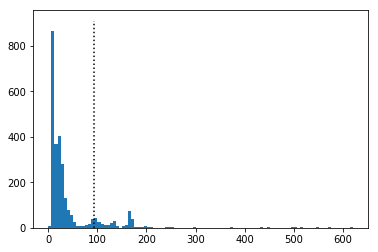

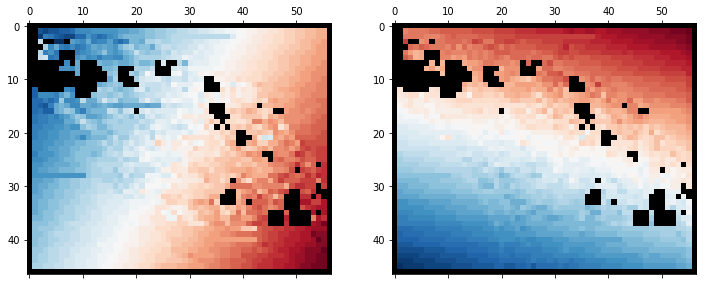

In [6]:
# Find outliers

n_sigma = 10
edge_boundary = 1
n_bins = 100

mask,n,bins,cutoff = find_outlier_shifts(xshifts,yshifts,n_sigma=n_sigma,edge_boundary=edge_boundary,n_bins=n_bins)

# Show
xshifts_masked = ma.masked_array(xshifts, mask)
yshifts_masked = ma.masked_array(yshifts, mask)
mask_display = ma.masked_array(mask, mask==False)

fig,ax = plt.subplots()
ax.bar(bins[:-1]+(bins[1]-bins[0])/2., n, (bins[1]-bins[0]), align='center')
ax.vlines(cutoff,0,ax.get_ylim()[1],linestyle=':')
plt.show()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(xshifts_masked,cmap="RdBu")
ax2.matshow(yshifts_masked,cmap="RdBu")
ax1.matshow(mask_display)
ax2.matshow(mask_display)
plt.show()

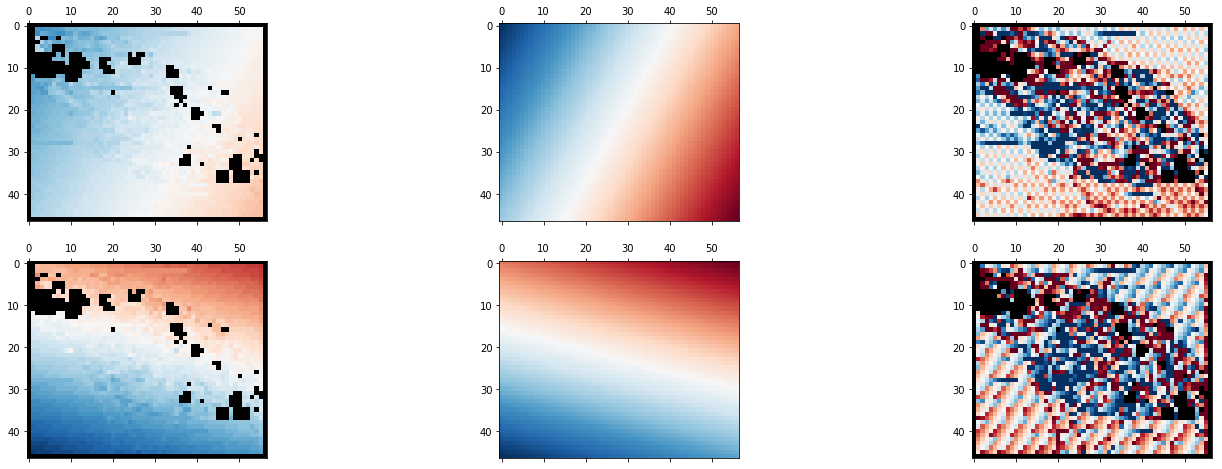

In [7]:
# Fit the diffraction shifts

fit_function = py4DSTEM.process.fit.plane        # Select fit type
#fit_function = py4DSTEM.process.fit.parabola

# Fit
xshifts_fit = np.zeros_like(xshifts)
yshifts_fit = np.zeros_like(yshifts)
popt_x, pcov_x, xshifts_fit = fit_2D(fit_function, xshifts, data_mask=mask==False)
popt_y, pcov_y, yshifts_fit = fit_2D(fit_function, yshifts, data_mask=mask==False)
residuals_x = xshifts-xshifts_fit
residuals_y = yshifts-yshifts_fit
residuals_x[mask] = 0
residuals_y[mask] = 0

# Show
fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(24,8))
ax11.matshow(xshifts,cmap="RdBu")
ax21.matshow(yshifts,cmap="RdBu")
ax12.matshow(xshifts_fit,cmap="RdBu")
ax22.matshow(yshifts_fit,cmap="RdBu")
ax13.matshow(residuals_x,cmap="RdBu",vmin=np.median(residuals_x)-np.std(residuals_x),vmax=np.median(residuals_x)+np.std(residuals_x))
ax23.matshow(residuals_y,cmap="RdBu",vmin=np.median(residuals_y)-np.std(residuals_y),vmax=np.median(residuals_y)+np.std(residuals_y))
ax11.matshow(mask_display)
ax21.matshow(mask_display)
ax13.matshow(mask_display)
ax23.matshow(mask_display)
plt.show()

### Apply shifts, calculate shift-corrected deconvolution

In [10]:
# Apply shifts

shifted_Braggpeaks = shift_braggpeaks(Braggpeak_pointlistarray, xshifts_fit, yshifts_fit)

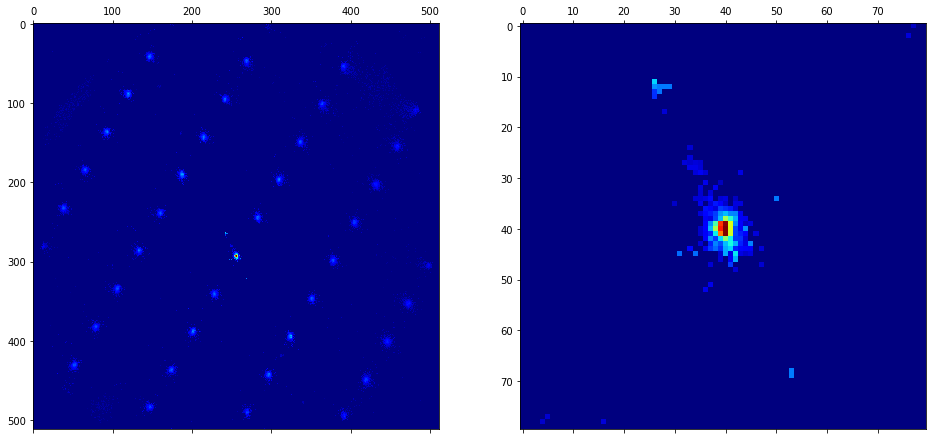

In [13]:
# Re-calculate average deconvolution and show

deconvolution = get_deconvolution(shifted_Braggpeaks,dc.Q_Nx,dc.Q_Ny)

# Show
x0,y0=np.unravel_index(np.argmax(gaussian_filter(deconvolution,2)),(dc.Q_Nx,dc.Q_Ny))
x0,y0=int(x0),int(y0)
rad=40

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution**0.25,cmap='jet')
ax2.matshow(deconvolution[x0-rad:x0+rad,y0-rad:y0+rad]**0.25,cmap='jet')
plt.show()

### (Optional) Create shift-corrected 4D datacube

In [20]:
# Apply shifts

data4D_corrected = np.empty_like(dc.data4D,dtype='float32')

from time import time
t0=time()
for i in range(dc.R_Nx):
    for j in range(dc.R_Ny):
        print("Shifting DP from scan position {},{}".format(i,j))
        data4D_corrected[i,j,:,:] = py4DSTEM.process.utils.get_shifted_ar(dc.data4D[i,j,:,:], 
                                                   -diffraction_shifts_fit.data2D['x'][i,j],
                                                   -diffraction_shifts_fit.data2D['y'][i,j])

t=time()-t0
print("Finished in {}h {}m {}s".format(int(t/3600),int(t/60),int(t%60)))

Shifting DP from scan position 0,0
Shifting DP from scan position 0,1
Shifting DP from scan position 0,2
Shifting DP from scan position 0,3
Shifting DP from scan position 0,4
Shifting DP from scan position 0,5
Shifting DP from scan position 0,6
Shifting DP from scan position 0,7
Shifting DP from scan position 0,8
Shifting DP from scan position 0,9
Shifting DP from scan position 0,10
Shifting DP from scan position 0,11
Shifting DP from scan position 0,12
Shifting DP from scan position 0,13
Shifting DP from scan position 0,14
Shifting DP from scan position 0,15
Shifting DP from scan position 0,16
Shifting DP from scan position 0,17
Shifting DP from scan position 0,18
Shifting DP from scan position 0,19
Shifting DP from scan position 0,20
Shifting DP from scan position 0,21
Shifting DP from scan position 0,22
Shifting DP from scan position 0,23
Shifting DP from scan position 0,24
Shifting DP from scan position 0,25
Shifting DP from scan position 0,26
Shifting DP from scan position 0,27
Sh

Shifting DP from scan position 4,5
Shifting DP from scan position 4,6
Shifting DP from scan position 4,7
Shifting DP from scan position 4,8
Shifting DP from scan position 4,9
Shifting DP from scan position 4,10
Shifting DP from scan position 4,11
Shifting DP from scan position 4,12
Shifting DP from scan position 4,13
Shifting DP from scan position 4,14
Shifting DP from scan position 4,15
Shifting DP from scan position 4,16
Shifting DP from scan position 4,17
Shifting DP from scan position 4,18
Shifting DP from scan position 4,19
Shifting DP from scan position 4,20
Shifting DP from scan position 4,21
Shifting DP from scan position 4,22
Shifting DP from scan position 4,23
Shifting DP from scan position 4,24
Shifting DP from scan position 4,25
Shifting DP from scan position 4,26
Shifting DP from scan position 4,27
Shifting DP from scan position 4,28
Shifting DP from scan position 4,29
Shifting DP from scan position 4,30
Shifting DP from scan position 4,31
Shifting DP from scan position 4,

Shifting DP from scan position 8,11
Shifting DP from scan position 8,12
Shifting DP from scan position 8,13
Shifting DP from scan position 8,14
Shifting DP from scan position 8,15
Shifting DP from scan position 8,16
Shifting DP from scan position 8,17
Shifting DP from scan position 8,18
Shifting DP from scan position 8,19
Shifting DP from scan position 8,20
Shifting DP from scan position 8,21
Shifting DP from scan position 8,22
Shifting DP from scan position 8,23
Shifting DP from scan position 8,24
Shifting DP from scan position 8,25
Shifting DP from scan position 8,26
Shifting DP from scan position 8,27
Shifting DP from scan position 8,28
Shifting DP from scan position 8,29
Shifting DP from scan position 8,30
Shifting DP from scan position 8,31
Shifting DP from scan position 8,32
Shifting DP from scan position 8,33
Shifting DP from scan position 8,34
Shifting DP from scan position 8,35
Shifting DP from scan position 8,36
Shifting DP from scan position 8,37
Shifting DP from scan positi

Shifting DP from scan position 12,10
Shifting DP from scan position 12,11
Shifting DP from scan position 12,12
Shifting DP from scan position 12,13
Shifting DP from scan position 12,14
Shifting DP from scan position 12,15
Shifting DP from scan position 12,16
Shifting DP from scan position 12,17
Shifting DP from scan position 12,18
Shifting DP from scan position 12,19
Shifting DP from scan position 12,20
Shifting DP from scan position 12,21
Shifting DP from scan position 12,22
Shifting DP from scan position 12,23
Shifting DP from scan position 12,24
Shifting DP from scan position 12,25
Shifting DP from scan position 12,26
Shifting DP from scan position 12,27
Shifting DP from scan position 12,28
Shifting DP from scan position 12,29
Shifting DP from scan position 12,30
Shifting DP from scan position 12,31
Shifting DP from scan position 12,32
Shifting DP from scan position 12,33
Shifting DP from scan position 12,34
Shifting DP from scan position 12,35
Shifting DP from scan position 12,36
S

Shifting DP from scan position 16,8
Shifting DP from scan position 16,9
Shifting DP from scan position 16,10
Shifting DP from scan position 16,11
Shifting DP from scan position 16,12
Shifting DP from scan position 16,13
Shifting DP from scan position 16,14
Shifting DP from scan position 16,15
Shifting DP from scan position 16,16
Shifting DP from scan position 16,17
Shifting DP from scan position 16,18
Shifting DP from scan position 16,19
Shifting DP from scan position 16,20
Shifting DP from scan position 16,21
Shifting DP from scan position 16,22
Shifting DP from scan position 16,23
Shifting DP from scan position 16,24
Shifting DP from scan position 16,25
Shifting DP from scan position 16,26
Shifting DP from scan position 16,27
Shifting DP from scan position 16,28
Shifting DP from scan position 16,29
Shifting DP from scan position 16,30
Shifting DP from scan position 16,31
Shifting DP from scan position 16,32
Shifting DP from scan position 16,33
Shifting DP from scan position 16,34
Shi

Shifting DP from scan position 20,8
Shifting DP from scan position 20,9
Shifting DP from scan position 20,10
Shifting DP from scan position 20,11
Shifting DP from scan position 20,12
Shifting DP from scan position 20,13
Shifting DP from scan position 20,14
Shifting DP from scan position 20,15
Shifting DP from scan position 20,16
Shifting DP from scan position 20,17
Shifting DP from scan position 20,18
Shifting DP from scan position 20,19
Shifting DP from scan position 20,20
Shifting DP from scan position 20,21
Shifting DP from scan position 20,22
Shifting DP from scan position 20,23
Shifting DP from scan position 20,24
Shifting DP from scan position 20,25
Shifting DP from scan position 20,26
Shifting DP from scan position 20,27
Shifting DP from scan position 20,28
Shifting DP from scan position 20,29
Shifting DP from scan position 20,30
Shifting DP from scan position 20,31
Shifting DP from scan position 20,32
Shifting DP from scan position 20,33
Shifting DP from scan position 20,34
Shi

Shifting DP from scan position 24,5
Shifting DP from scan position 24,6
Shifting DP from scan position 24,7
Shifting DP from scan position 24,8
Shifting DP from scan position 24,9
Shifting DP from scan position 24,10
Shifting DP from scan position 24,11
Shifting DP from scan position 24,12
Shifting DP from scan position 24,13
Shifting DP from scan position 24,14
Shifting DP from scan position 24,15
Shifting DP from scan position 24,16
Shifting DP from scan position 24,17
Shifting DP from scan position 24,18
Shifting DP from scan position 24,19
Shifting DP from scan position 24,20
Shifting DP from scan position 24,21
Shifting DP from scan position 24,22
Shifting DP from scan position 24,23
Shifting DP from scan position 24,24
Shifting DP from scan position 24,25
Shifting DP from scan position 24,26
Shifting DP from scan position 24,27
Shifting DP from scan position 24,28
Shifting DP from scan position 24,29
Shifting DP from scan position 24,30
Shifting DP from scan position 24,31
Shifti

Shifting DP from scan position 28,9
Shifting DP from scan position 28,10
Shifting DP from scan position 28,11
Shifting DP from scan position 28,12
Shifting DP from scan position 28,13
Shifting DP from scan position 28,14
Shifting DP from scan position 28,15
Shifting DP from scan position 28,16
Shifting DP from scan position 28,17
Shifting DP from scan position 28,18
Shifting DP from scan position 28,19
Shifting DP from scan position 28,20
Shifting DP from scan position 28,21
Shifting DP from scan position 28,22
Shifting DP from scan position 28,23
Shifting DP from scan position 28,24
Shifting DP from scan position 28,25
Shifting DP from scan position 28,26
Shifting DP from scan position 28,27
Shifting DP from scan position 28,28
Shifting DP from scan position 28,29
Shifting DP from scan position 28,30
Shifting DP from scan position 28,31
Shifting DP from scan position 28,32
Shifting DP from scan position 28,33
Shifting DP from scan position 28,34
Shifting DP from scan position 28,35
Sh

Shifting DP from scan position 32,9
Shifting DP from scan position 32,10
Shifting DP from scan position 32,11
Shifting DP from scan position 32,12
Shifting DP from scan position 32,13
Shifting DP from scan position 32,14
Shifting DP from scan position 32,15
Shifting DP from scan position 32,16
Shifting DP from scan position 32,17
Shifting DP from scan position 32,18
Shifting DP from scan position 32,19
Shifting DP from scan position 32,20
Shifting DP from scan position 32,21
Shifting DP from scan position 32,22
Shifting DP from scan position 32,23
Shifting DP from scan position 32,24
Shifting DP from scan position 32,25
Shifting DP from scan position 32,26
Shifting DP from scan position 32,27
Shifting DP from scan position 32,28
Shifting DP from scan position 32,29
Shifting DP from scan position 32,30
Shifting DP from scan position 32,31
Shifting DP from scan position 32,32
Shifting DP from scan position 32,33
Shifting DP from scan position 32,34
Shifting DP from scan position 32,35
Sh

Shifting DP from scan position 36,9
Shifting DP from scan position 36,10
Shifting DP from scan position 36,11
Shifting DP from scan position 36,12
Shifting DP from scan position 36,13
Shifting DP from scan position 36,14
Shifting DP from scan position 36,15
Shifting DP from scan position 36,16
Shifting DP from scan position 36,17
Shifting DP from scan position 36,18
Shifting DP from scan position 36,19
Shifting DP from scan position 36,20
Shifting DP from scan position 36,21
Shifting DP from scan position 36,22
Shifting DP from scan position 36,23
Shifting DP from scan position 36,24
Shifting DP from scan position 36,25
Shifting DP from scan position 36,26
Shifting DP from scan position 36,27
Shifting DP from scan position 36,28
Shifting DP from scan position 36,29
Shifting DP from scan position 36,30
Shifting DP from scan position 36,31
Shifting DP from scan position 36,32
Shifting DP from scan position 36,33
Shifting DP from scan position 36,34
Shifting DP from scan position 36,35
Sh

Shifting DP from scan position 40,13
Shifting DP from scan position 40,14
Shifting DP from scan position 40,15
Shifting DP from scan position 40,16
Shifting DP from scan position 40,17
Shifting DP from scan position 40,18
Shifting DP from scan position 40,19
Shifting DP from scan position 40,20
Shifting DP from scan position 40,21
Shifting DP from scan position 40,22
Shifting DP from scan position 40,23
Shifting DP from scan position 40,24
Shifting DP from scan position 40,25
Shifting DP from scan position 40,26
Shifting DP from scan position 40,27
Shifting DP from scan position 40,28
Shifting DP from scan position 40,29
Shifting DP from scan position 40,30
Shifting DP from scan position 40,31
Shifting DP from scan position 40,32
Shifting DP from scan position 40,33
Shifting DP from scan position 40,34
Shifting DP from scan position 40,35
Shifting DP from scan position 40,36
Shifting DP from scan position 40,37
Shifting DP from scan position 40,38
Shifting DP from scan position 40,39
S

Shifting DP from scan position 44,9
Shifting DP from scan position 44,10
Shifting DP from scan position 44,11
Shifting DP from scan position 44,12
Shifting DP from scan position 44,13
Shifting DP from scan position 44,14
Shifting DP from scan position 44,15
Shifting DP from scan position 44,16
Shifting DP from scan position 44,17
Shifting DP from scan position 44,18
Shifting DP from scan position 44,19
Shifting DP from scan position 44,20
Shifting DP from scan position 44,21
Shifting DP from scan position 44,22
Shifting DP from scan position 44,23
Shifting DP from scan position 44,24
Shifting DP from scan position 44,25
Shifting DP from scan position 44,26
Shifting DP from scan position 44,27
Shifting DP from scan position 44,28
Shifting DP from scan position 44,29
Shifting DP from scan position 44,30
Shifting DP from scan position 44,31
Shifting DP from scan position 44,32
Shifting DP from scan position 44,33
Shifting DP from scan position 44,34
Shifting DP from scan position 44,35
Sh

In [19]:
# Store new, shifted datacube
datacube_shifted = py4DSTEM.process.datastructure.DataCube(data=data4D_corrected,
                                                           parentDataCube=dc, 
                                                           name="shift_corrected_datacube")